<a href="https://colab.research.google.com/github/Paridhi004/Text-Summarization/blob/main/TOPSIS_Based_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:

# Step 1: Model performance table for Text Summarization
data = pd.read_csv("/content/evaluation_scores.csv")

print("Original Model Comparison Data:")
print(data)

Original Model Comparison Data:
      domain model   rouge1   rouge2   rougeL  semantic_similarity  \
0    Finance    M1  0.59834  0.57140  0.59834              0.87544   
1    Finance    M2  0.50734  0.47146  0.50478              0.84728   
2    Finance    M3  0.02076  0.00000  0.01862              0.05314   
3    Finance    M4  0.98436  0.98422  0.98436              0.99176   
4    Finance    M5  0.63402  0.59844  0.63144              0.89040   
5      Music    M1  0.57188  0.54674  0.57188              0.84570   
6      Music    M2  0.55268  0.52174  0.55268              0.83458   
7      Music    M3  0.01690  0.00000  0.01312              0.00778   
8      Music    M4  0.97674  0.97650  0.97674              0.99080   
9      Music    M5  0.60698  0.56976  0.60448              0.86294   
10  Politics    M1  0.59562  0.55404  0.59332              0.84642   
11  Politics    M2  0.52868  0.43376  0.49544              0.81854   
12  Politics    M3  0.01674  0.00000  0.01674             

In [7]:
criteria_matrix = data[['rouge1','rouge2', 'rougeL', 'inference_time', 'compression_ratio' , 'semantic_similarity']].values

In [33]:
unique_domains = data['domain'].unique()
best_models_per_domain = []

weights = np.array([0.15, 0.15, 0.20, 0.15, 0.10, 0.25]) # rouge1, rouge2, rougeL, inference_time, compression_ratio, semantic_similarity

for domain in unique_domains:
    print(f"\nProcessing domain: {domain}")
    domain_df = data[data['domain'] == domain].copy()

    # Extract criteria matrix for the current domain
    domain_criteria_matrix = domain_df[['rouge1', 'rouge2', 'rougeL', 'inference_time', 'compression_ratio', 'semantic_similarity']].values

    # Normalize the matrix for the current domain
    domain_norm_matrix = domain_criteria_matrix / np.sqrt((domain_criteria_matrix**2).sum(axis=0))

    # Apply weights to the normalized matrix
    domain_weighted_matrix = domain_norm_matrix * weights

    # Ideal best and worst solutions for the current domain
    domain_ideal_best = np.array([
        domain_weighted_matrix[:, 0].max(),   # ROUGE-1 (Benefit) - max
        domain_weighted_matrix[:, 1].max(),   # ROUGE-2 (Benefit) - max
        domain_weighted_matrix[:, 2].max(),   # ROUGE-L (Benefit) - max
        domain_weighted_matrix[:, 3].min(),   # Inference Time (Cost) - min
        domain_weighted_matrix[:, 4].min(),   # Compression Ratio (Cost) - min
        domain_weighted_matrix[:, 5].max()    # Semantic Similarity (Benefit) - max
    ])

    domain_ideal_worst = np.array([
        domain_weighted_matrix[:, 0].min(),
        domain_weighted_matrix[:, 1].min(),
        domain_weighted_matrix[:, 2].min(),
        domain_weighted_matrix[:, 3].max(),
        domain_weighted_matrix[:, 4].max(),
        domain_weighted_matrix[:, 5].min()
    ])

    # Distance calculation for the current domain
    domain_distance_best = np.sqrt(((domain_weighted_matrix - domain_ideal_best) ** 2).sum(axis=1))
    domain_distance_worst = np.sqrt(((domain_weighted_matrix - domain_ideal_worst) ** 2).sum(axis=1))

    # TOPSIS score for the current domain
    domain_topsis_score = domain_distance_worst / (domain_distance_best + domain_distance_worst)

    domain_df["TOPSIS Score"] = domain_topsis_score
    domain_df["Rank"] = domain_df["TOPSIS Score"].rank(ascending=False, method='first')

    best_model_in_domain = domain_df.sort_values(by="TOPSIS Score", ascending=False).iloc[0]
    best_models_per_domain.append(best_model_in_domain)

    print(f"TOPSIS Ranking for {domain} domain:")
    print(domain_df[['model', 'TOPSIS Score', 'Rank']].sort_values("Rank"))

final_best_models_df = pd.DataFrame(best_models_per_domain)
print("\nSummary of Best Models per Domain:")
print(final_best_models_df[['domain', 'model', 'TOPSIS Score', 'Rank']])


Processing domain: Finance
TOPSIS Ranking for Finance domain:
  model  TOPSIS Score  Rank
3    M4      0.821411   1.0
4    M5      0.710442   2.0
0    M1      0.674281   3.0
1    M2      0.629100   4.0
2    M3      0.057887   5.0

Processing domain: Music
TOPSIS Ranking for Music domain:
  model  TOPSIS Score  Rank
8    M4      0.831533   1.0
9    M5      0.700483   2.0
5    M1      0.665720   3.0
6    M2      0.661715   4.0
7    M3      0.072086   5.0

Processing domain: Politics
TOPSIS Ranking for Politics domain:
   model  TOPSIS Score  Rank
13    M4      0.779293   1.0
14    M5      0.701138   2.0
10    M1      0.653369   3.0
11    M2      0.594243   4.0
12    M3      0.094561   5.0

Processing domain: Sports
TOPSIS Ranking for Sports domain:
   model  TOPSIS Score  Rank
18    M4      0.821347   1.0
19    M5      0.681124   2.0
15    M1      0.618352   3.0
16    M2      0.609775   4.0
17    M3      0.088439   5.0

Summary of Best Models per Domain:
      domain model  TOPSIS Score

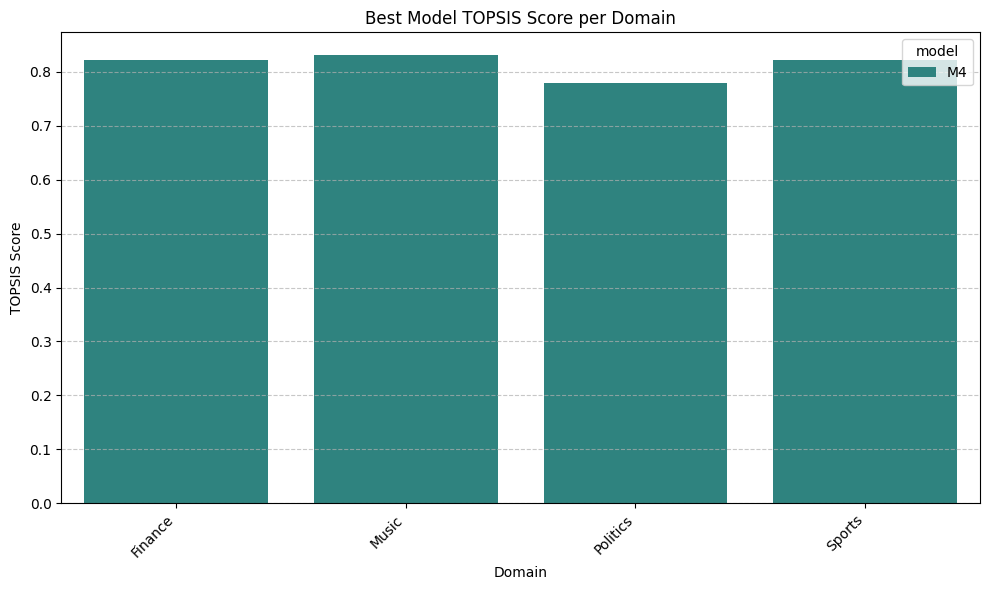

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='domain', y='TOPSIS Score', data=final_best_models_df, hue='model', palette='viridis', dodge=False)
plt.title('Best Model TOPSIS Score per Domain')
plt.xlabel('Domain')
plt.ylabel('TOPSIS Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

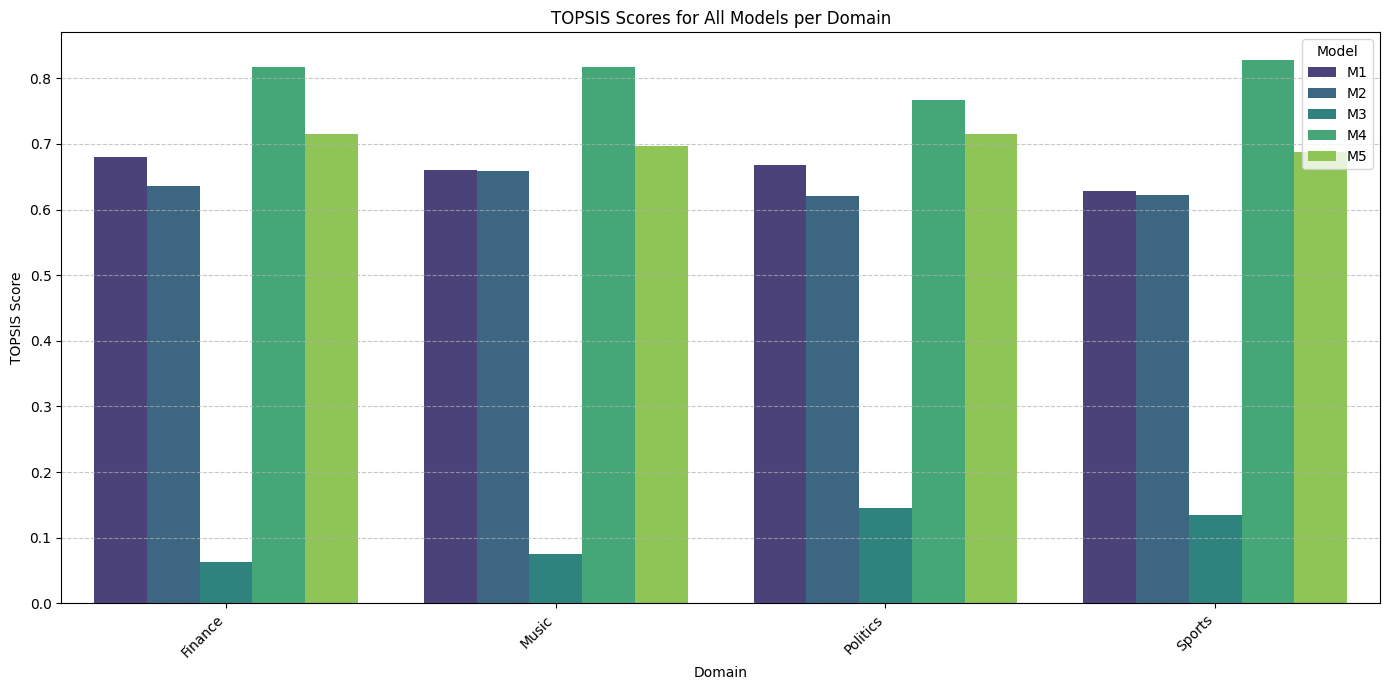

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.barplot(x='domain', y='TOPSIS Score', hue='model', data=data, palette='viridis')
plt.title('TOPSIS Scores for All Models per Domain')
plt.xlabel('Domain')
plt.ylabel('TOPSIS Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()